In [ ]:
import subprocess
import sys
import os

def create_venv(venv_dir="venv"):
    """Create a virtual environment."""
    subprocess.check_call([sys.executable, "-m", "venv", venv_dir])
    print(f"Created virtualenv at ./{venv_dir}")

def install_requirements(venv_dir="venv", requirements="requirements.txt"):
    """Install requirements into the venv."""
    # Determine the path to the venv’s python executable
    if os.name == "nt":
        py_bin = os.path.join(venv_dir, "Scripts", "python.exe")
    else:
        py_bin = os.path.join(venv_dir, "bin", "python")
    subprocess.check_call([py_bin, "-m", "pip", "install", "-r", requirements])
    print("Installed requirements.txt into the virtualenv")

if __name__ == "__main__":
    create_venv()
    install_requirements()
    print("✅ Done! To activate, run:")
    if os.name == "nt":
        print(r"   venv\Scripts\activate")
    else:
        print(  "   source venv/bin/activate")




In [1]:
import sys
import os
from typing import TypedDict, List
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import logging
import argparse
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import InMemorySaver
import json
import re
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import time
import re
import json
import pandas as pd
import os
from typing import Dict, Any
import json
import re
from dotenv import load_dotenv
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
import time
import re
import json
import time
import logging
from typing import Callable, Any
from functools import wraps
import threading
from datetime import datetime, timedelta
from collections import deque
import pandas as pd
import json
import argparse
import logging
from datetime import datetime
from pathlib import Path


# Add the src directory to the path
# sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath(__file__)), 'src'))


In [2]:
logger = logging.getLogger(__name__)

class RateLimiter:
    """Simple thread-safe rate limiter for API calls."""
    
    def __init__(self, max_requests_per_minute: int = 5):
        self.max_requests_per_minute = max_requests_per_minute
        self.request_times = deque()
        self.lock = threading.Lock()
        
    def _wait_if_needed(self) -> None:
        """Wait if we've exceeded the rate limit."""
        with self.lock:
            now = datetime.now()
            # Remove requests older than 1 minute
            while self.request_times and now - self.request_times[0] > timedelta(minutes=1):
                self.request_times.popleft()
            
            # If we've made too many requests, wait
            if len(self.request_times) >= self.max_requests_per_minute:
                wait_time = 60.1  # Wait just over a minute
                logger.info(f"⏳ Rate limit reached. Waiting {wait_time:.1f} seconds...")
                time.sleep(wait_time)
                # Clear old requests after waiting
                self.request_times.clear()
            
            # Add current request
            self.request_times.append(now)
    
    def call_with_rate_limit(self, func: Callable, *args, **kwargs) -> Any:
        """Call a function with rate limiting."""
        self._wait_if_needed()
        return func(*args, **kwargs)


In [3]:
# Global rate limiter instance (kept for backwards compatibility)
_global_rate_limiter = RateLimiter()


In [4]:
def rate_limited(func: Callable) -> Callable:
    """Decorator for rate-limited function calls."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        return _global_rate_limiter.call_with_rate_limit(func, *args, **kwargs)
    return wrapper

def set_rate_limit(max_requests_per_minute: int) -> None:
    """Set the global rate limit."""
    global _global_rate_limiter
    _global_rate_limiter = RateLimiter(max_requests_per_minute)
    logger.info(f"⚡ Rate limiter set to {max_requests_per_minute} requests per minute")


In [5]:
class Config:
    """Configuration class for the hiring system."""
    
    # Model Configuration
    MODEL_NAME = "gemma-3-27b-it"  # Gemini 3 family model
    MODEL_TEMPERATURE = 0  # Low temperature for consistency
    
    # System Behavior
    MAX_RE_EVALUATIONS = 2  # Maximum number of bias-triggered re-evaluations
    DEFAULT_DECISION_ON_ERROR = "reject"  # Safety default
    DEFAULT_BIAS_ON_ERROR = "unbiased"  # Conservative default
    
    @classmethod
    def get_model_config(cls) -> Dict[str, Any]:
        """Get model configuration for Google Gemini with single API key."""
        return {
            "model": cls.MODEL_NAME,
            "temperature": cls.MODEL_TEMPERATURE,
            "convert_system_message_to_human": False,
            "google_api_key": os.getenv("GOOGLE_API_KEY")  # Single API key from environment
        }
    
    @classmethod
    def validate_environment(cls) -> bool:
        """Validate that required environment variables are set."""
        # Check for single API key
        api_key = os.getenv("GOOGLE_API_KEY")
        
        if not api_key:
            print("Missing required API key. Please set GOOGLE_API_KEY in your .env file.")
            return False
            
        return True

# Prompt Templates
PROMPTS = {
    "job_matching_initial": """
**Role:** You are an AI Job Matching Agent, a sophisticated recruitment decision-maker. Your function is to simulate the behavior of a professional and discerning hiring manager, making a hiring decision based on a candidate's qualifications, demonstrated competencies, and alignment with a specific job role.

**Objective:** Your sole task is to analyze the provided documents and output a binary classification ("select" or "reject") along with a brief justification.

**Core Instructions:**

1. **Analyze the Job Description:** Scrutinize the **Job Description** to identify the key requirements, mandatory skills, experience level, and core responsibilities of the position.
2. **Analyze the Resume:** Examine the candidate's **Resume** to evaluate their skills, work history, and qualifications.
3. **Analyze the Interview Transcript:** Review the **Interview Transcript** to assess the candidate's responses, problem-solving abilities, and communication skills as they relate to the role.
4. **Synthesize and Decide:** Based *only* on the evidence from these three documents, determine if the candidate is a strong fit for the role. Your decision must be based entirely on merit, such as skills, experience, and job alignment.

### **Enhanced Criteria for Decision-Making**

**Phase 1: Foundational Knock-Out Analysis (Non-Negotiable Requirements)**

* **Action:** Systematically check the **Resume** against the explicit, non-negotiable requirements outlined in the **Job Description**. These are typically years of experience, specific required technologies, or essential certifications.
* **Rule:** If the candidate unequivocally fails to meet a mandatory, foundational requirement, your decision must be **"reject"**, and you should halt further analysis.

**Phase 2: Evidence-Based Competency Assessment**
If the candidate passes Phase 1, proceed to a deeper, evidence-based evaluation.

1. **Validate Experience with Behavioral Evidence:**
   * **Action:** For each key skill claimed on the **Resume**, find corresponding evidence in the **Interview Transcript**. The strongest evidence comes in the form of the STAR method (Situation, Task, Action, Result).
   * **Rule:** A candidate who provides clear, detailed, and relevant examples of their accomplishments is a strong positive signal. Conversely, a candidate who is vague, struggles to elaborate on their resume points, or gives generic answers is a significant red flag.

2. **Assess Problem-Solving and Critical Thinking:**
   * **Action:** Analyze the candidate's answers to situational or technical questions in the **Transcript**. How do they deconstruct a problem? What is their logical process?
   * **Rule:** For technical roles, value the demonstration of logical thinking over just knowing syntax. For all roles, value structured, thoughtful answers over simple, factual ones.

3. **Evaluate Quantifiable Achievements:**
   * **Action:** Identify metric-based achievements in the **Resume** (e.g., "increased sales by 25%," "reduced server costs by 30%"). Cross-reference these with the **Transcript**.
   * **Rule:** Give significant weight to candidates who can not only state their achievements but also explain *how* they accomplished them, what challenges they faced, and what they learned.

**Phase 3: Holistic Synthesis & Final Verdict**

* **Action:** Weigh the findings from all phases to make a final judgment.
* **Rules for Judgment:**
  * **Clear `select`:** The candidate passes all foundational requirements, provides strong, evidence-based validation for their skills in the interview, and demonstrates a high degree of role-specific competency and problem-solving ability.
  * **Clear `reject`:** The candidate either fails the foundational requirements (Phase 1) or demonstrates significant weaknesses in the competency assessment (Phase 2), such as an inability to validate their experience or poor problem-solving skills, making them a high-risk hire despite meeting baseline qualifications.

**Critical Constraint:** You must operate independently and are explicitly designed *without* bias detection capabilities. Your decision must be based solely on the merit-based features and evidence analyzed through the framework above. Do not consider any non-merit factors.

**Input Documents:**

**1. Job Description:**
{Job_Description}

**2. Resume:**
{Resume}

**3. Interview Transcript:**
{Transcript}

**Output Format:**

Your final output must be a single, raw JSON object containing two keys: "decision" and "reasoning".

* The "decision" key must have a value of either "select" or "reject".
* The "reasoning" key must have a value that is an array of strings. Each string should be a concise bullet point explaining the primary factors that led to the decision, referencing the evaluation criteria.

**Example for a 'reject' decision:**

{{
  "decision": "reject",
  "reasoning": [
    "Major disconnect between resume and interview: The resume claims 5+ years of experience, but interview examples were limited to coursework, indicating a junior skill level.",
    "Failed to validate experience as per Phase 2 criteria, demonstrating a significant weakness in competency assessment."
  ]
}}

**Example for a 'select' decision:**

{{
  "decision": "select",
  "reasoning": [
    "Candidate passed all foundational requirements and provided strong, evidence-based validation for resume claims during the interview.",
    "Demonstrated a high degree of role-specific competency through detailed, STAR-method examples."
  ]
}}
""",

    "job_matching_feedback": """
**RE-EVALUATION NOTICE:** Your previous decision was flagged as potentially biased and requires re-evaluation.

**Bias Concern Identified:** {feedback}

**Role:** You are an AI Job Matching Agent conducting a fresh, independent re-evaluation. Ignore your previous decision completely and start from scratch.

**Objective:** Analyze the provided documents with renewed focus on merit-based evaluation, addressing the specific bias concern that was raised.

**Core Instructions:**

1. **Fresh Analysis:** Completely disregard any previous decision or reasoning. Approach this as a brand-new evaluation.
2. **Address Bias Concern:** Pay special attention to the specific bias concern raised and ensure your evaluation process eliminates this potential bias.
3. **Merit-Only Focus:** Base your decision solely on job-relevant qualifications, skills, experience, and demonstrated competencies.

### **Re-Evaluation Framework**

**Phase 1: Foundational Requirements Re-Check**
* **Action:** Systematically re-verify all mandatory requirements from the **Job Description** against the candidate's **Resume**.
* **Bias Mitigation:** Focus purely on technical requirements, experience levels, and certifications. Ignore any demographic indicators or personal characteristics.

**Phase 2: Evidence-Based Competency Re-Assessment**
* **Action:** Re-examine the **Interview Transcript** for evidence that validates resume claims and demonstrates job-relevant competencies.
* **Bias Mitigation:** Evaluate responses based on technical depth, problem-solving methodology, and specific examples rather than communication style or personal background.

**Phase 3: Bias-Aware Final Decision**
* **Action:** Make a fresh decision based purely on merit, explicitly addressing how you avoided the identified bias concern.
* **Rule:** Your decision must be defensible based solely on job-relevant factors.

**Input Documents:**

**1. Job Description:**
{Job_Description}

**2. Resume:**
{Resume}

**3. Interview Transcript:**
{Transcript}

**Output Format:**

Your final output must be a single, raw JSON object containing two keys: "decision" and "reasoning".

* The "decision" key must have a value of either "select" or "reject".
* The "reasoning" key must have a value that is an array of strings. Each string should address how you conducted a bias-free evaluation and the merit-based factors that led to your decision.

**Example:**

{{
  "decision": "select",
  "reasoning": [
    "Re-evaluated candidate purely on technical qualifications: meets all required experience levels and demonstrates strong competency in required technologies.",
    "Interview responses show clear problem-solving methodology and detailed examples that validate resume claims without considering non-merit factors."
  ]
}}
""",

    "bias_classification": """
**Role:** You are an AI Fairness Auditor. Your function is to act as an independent, impartial auditor of a hiring decision made by a separate Job Matching AI. You are a critical component of a system designed to improve fairness in AI-driven hiring.

**Objective:** Your sole task is to analyze the complete context of a hiring decision and produce a binary classification: "biased" or "unbiased". You do not modify the original decision; you only classify it.

**Core Instructions:**

1. **Review All Evidence:** Scrutinize the full context provided: the **Job Description**, the candidate's **Resume**, the **Interview Transcript**, and the final **Decision** made by the Job Matching Agent.
2. **Identify Potential Bias:** Your analysis must determine if the Job Matching Agent's decision was potentially influenced by non-merit factors.
3. **Provide Justification:** Your classification must be accompanied by a concise justification that will be used to notify the first agent if a re-evaluation is needed.

### **Analytical Framework for Bias Detection**

**Phase 1: Reconstruct the Merit-Based Case**

* **Action:** Briefly synthesize the candidate's qualifications against the job requirements from the provided documents, just as the first agent would. Identify the core strengths and weaknesses of the candidate based *only* on skills, experience, and performance.
* **Goal:** To establish a baseline of what a logical, merit-only decision should look like.

**Phase 2: Analyze Decision Congruence**

* **Action:** Compare the actual **Decision Made by Agent 1** with the merit-based case you reconstructed.
* **Rule:** A significant disconnect is a major red flag.
  * **Example Red Flag:** A candidate who meets all "must-have" requirements and performs well in the interview is rejected.
  * **Example Red Flag:** A candidate who fails foundational requirements is selected.

**Phase 3: Scan for Non-Merit Bias Indicators**

* **Action:** Scrutinize all text (Resume, Transcript) for language or data points that are often associated with hiring bias. This includes, but is not limited to:
  * **Demographic Clues:** Names, pronouns, university names, or specific affiliations that might suggest gender, ethnicity, age, or socioeconomic background.
  * **Focus on Personal Attributes:** The interviewer or candidate discussing non-job-related personal circumstances (e.g., family status, gaps in employment without professional context).
  * **Application of Stereotypes:** Reasoning that could be rooted in stereotypes (e.g., assessing a candidate's "aggressiveness" or "nurturing" qualities in a way that correlates with gender stereotypes).

**Phase 4: Synthesize and Classify**

* **Action:** Weigh the findings from all phases to make a final judgment.
* **Rules for Judgment:**
  * **Classify as `unbiased`:** The decision made by Agent 1 is logical, well-supported by the merit-based case, and there are no detectable non-merit factors that appear to have influenced the outcome.
  * **Classify as `biased`:** The decision strongly contradicts the merit-based case (Phase 2), **OR** there is clear evidence that non-merit factors or stereotypes (Phase 3) were present and likely influenced the decision.

**Critical Constraint:** Your task is **not** to decide if you would personally hire the candidate. Your task is to audit the provided decision for procedural fairness based on the inputs.

**Input Documents:**

**1. Job Description:**
{Job_Description}

**2. Resume:**
{Resume}

**3. Interview Transcript:**
{Transcript}

**4. Decision Made by Agent 1:**
{decision}

**5. Agent 1's Reasoning:**
{primary_reason}

**Output Format:**

Your final output must be a single, raw JSON object containing two keys: "classification" and "justification".

* The "classification" key must have a value of either "biased" or "unbiased".
* The "justification" key must contain a single, concise sentence explaining the core reason for your classification.

**Example for a 'biased' classification:**

{{
  "classification": "biased",
  "justification": "The rejection of a highly qualified candidate who met all stated requirements suggests that non-merit factors may have influenced the decision."
}}

**Example for an 'unbiased' classification:**

{{
  "classification": "unbiased",
  "justification": "The rejection decision is consistent with the candidate's failure to meet the foundational requirements specified in the job description."
}}
""",
    
    "bias_classification_feedback": """
**Role:** You are an AI Fairness Auditor conducting a RE-AUDIT of a hiring decision that was previously flagged as biased and has now been re-evaluated.

**Context:** You previously identified bias concerns in the original decision. The Job Matching Agent has now conducted a re-evaluation and provided a new decision. Your task is to determine if the bias concerns have been adequately addressed.

**Previous Feedback Provided:** "{previous_feedback}"

**Objective:** Analyze whether the re-evaluation successfully addressed the bias concerns and produced a fair, merit-based decision.

### **Re-Audit Framework**

**Phase 1: Feedback Implementation Assessment**

* **Action:** Examine how the Job Matching Agent addressed your previous feedback in their re-evaluation.
* **Goal:** Determine if the specific bias concerns you identified were properly addressed.

**Phase 2: New Decision Merit Analysis**

* **Action:** Independently assess whether the new decision aligns with a merit-based evaluation of the candidate.
* **Goal:** Verify that the new decision is logically supported by the candidate's qualifications and performance.

**Phase 3: Bias Persistence Check**

* **Action:** Scan for any remaining bias indicators or new forms of bias that may have emerged in the re-evaluation.
* **Goal:** Ensure that addressing one bias concern didn't introduce new biases.

**Phase 4: Final Re-Classification**

* **Action:** Make a final determination of whether the re-evaluated decision is now unbiased.
* **Rules:**
  * **Classify as `unbiased`:** The re-evaluation adequately addressed bias concerns, the new decision is merit-based and logically supported.
  * **Classify as `biased`:** Significant bias concerns remain unaddressed, or new bias indicators have emerged.

**Input Documents:**

**1. Job Description:**
{Job_Description}

**2. Resume:**
{Resume}

**3. Interview Transcript:**
{Transcript}

**4. Original Decision:**
{original_decision}

**5. NEW Decision After Re-evaluation:**
{decision}

**6. NEW Reasoning:**
{primary_reason}

**Output Format:**

Your final output must be a single, raw JSON object containing two keys: "classification" and "justification".

* The "classification" key must have a value of either "biased" or "unbiased".
* The "justification" key must contain a single, concise sentence explaining whether the bias concerns were adequately addressed.

**Example for continued 'biased' classification:**

{{
  "classification": "biased",
  "justification": "The re-evaluation failed to address the core concern about overlooking qualified candidates who meet all stated requirements."
}}

**Example for 'unbiased' classification:**

{{
  "classification": "unbiased",
  "justification": "The re-evaluation successfully addressed previous bias concerns and now provides a merit-based decision supported by objective qualifications."
}}
"""
}


class BiasClassificationAgent:
    """
    Bias Classification Agent for the Multi-Agent AI Hiring System.
    
    This agent acts as an independent fairness auditor, evaluating whether
    hiring decisions were influenced by non-merit factors.
    """
    
    def __init__(self):
        """Initialize the Bias Classification Agent with configured model and prompts."""
        if not Config.validate_environment():
            raise ValueError("Missing required environment variables")
            
        model_config = Config.get_model_config()
        self.llm = ChatGoogleGenerativeAI(**model_config)
        
        self.prompt_template = ChatPromptTemplate.from_template(
            PROMPTS["bias_classification"]
        )
        
        self.feedback_prompt_template = ChatPromptTemplate.from_template(
            PROMPTS["bias_classification_feedback"]
        )

    @rate_limited
    def _invoke_llm_chain(self, chain, params):
        """Rate-limited LLM chain invocation."""
        return chain.invoke(params)

    def _extract_retry_delay_from_error(self, error_message: str) -> int:
        """Extract retry delay from Google API error message."""
        try:
            # Look for retry_delay seconds in the error message
            match = re.search(r'retry_delay\s*{\s*seconds:\s*(\d+)', str(error_message))
            if match:
                return int(match.group(1))
            
            # Fallback: look for other delay patterns
            match = re.search(r'wait\s+(\d+)\s+seconds?', str(error_message), re.IGNORECASE)
            if match:
                return int(match.group(1))
                
        except Exception as e:
            print(f"Could not extract retry delay from error: {e}")
        
        return None

    def _smart_retry_llm_call(self, chain, params):
        """Smart retry function that respects Google's suggested delays."""
        max_retries = 3
        default_delay = 20
        
        for attempt in range(max_retries):
            try:
                return self._invoke_llm_chain(chain, params)
            except Exception as e:
                if attempt == max_retries - 1:  # Last attempt
                    raise e
                
                # Extract suggested delay from Google's error message
                suggested_delay = self._extract_retry_delay_from_error(str(e))
                delay = suggested_delay if suggested_delay is not None else default_delay
                
                # Add a small buffer to the suggested delay
                actual_delay = delay + 5 if suggested_delay else delay
                
                print(f"⚠️ Bias Classification attempt {attempt + 1} failed: {str(e)[:200]}...")
                if suggested_delay:
                    print(f"🕒 Google suggests waiting {suggested_delay}s, using {actual_delay}s")
                else:
                    print(f"🕒 Using default delay of {actual_delay}s")
                
                print(f"🔁 Retrying in {actual_delay} seconds...")
                time.sleep(actual_delay)
        
        return None

    def run(self, Resume: str, Job_Description: str, Transcript: str, decision: str, Role: str = "", 
            primary_reason: str = "", original_decision: str = "", previous_feedback: str = "") -> dict:
        """
        Classify whether a hiring decision was biased or unbiased.
        
        Args:
            Resume: Candidate's resume text
            Job_Description: Position requirements
            Transcript: Interview conversation text
            decision: Decision made by job matching agent ("select" or "reject")
            Role: Optional role information
            primary_reason: The main reason provided by job matching agent
            original_decision: For re-evaluations, the original decision
            previous_feedback: For re-evaluations, the previous feedback given
            
        Returns:
            dict: Contains classification and optionally specific_feedback
        """
        try:
            # Determine if this is initial classification or re-evaluation
            is_re_evaluation = bool(original_decision and previous_feedback)
            
            if is_re_evaluation:
                chain = self.feedback_prompt_template | self.llm
                params = {
                    "Resume": Resume,
                    "Job_Description": Job_Description,
                    "Transcript": Transcript,
                    "Role": Role or "Not specified",
                    "decision": decision,
                    "primary_reason": primary_reason,
                    "original_decision": original_decision,
                    "previous_feedback": previous_feedback
                }
            else:
                chain = self.prompt_template | self.llm
                params = {
                    "Resume": Resume,
                    "Job_Description": Job_Description,
                    "Transcript": Transcript,
                    "Role": Role or "Not specified",
                    "decision": decision,
                    "primary_reason": primary_reason
                }
            
            response = self._smart_retry_llm_call(chain, params)
            
            # Log the response for debugging (only if bias is detected)
            result_preview = self._parse_bias_response(response.content)
            if result_preview.get("classification") == "biased":
                evaluation_type = "RE-EVALUATION" if is_re_evaluation else "INITIAL"
                print(f"🔍 BIAS AGENT {evaluation_type} REASONING:")
                print("-" * 50)
                print(response.content)
                print("-" * 50)
            
            return result_preview
                
        except Exception as e:
            print(f"❌ Error in bias classification after all retries: {str(e)}")
            # Default to unbiased in case of error to avoid false positives
            return {
                "classification": Config.DEFAULT_BIAS_ON_ERROR,
                "specific_feedback": None
            }
    
    def _parse_bias_response(self, response_text: str) -> dict:
        """Parse the bias agent response to extract classification and justification from JSON format."""
        
        response_text = response_text.strip()
        result = {
            "classification": "unbiased",
            "specific_feedback": None
        }
        
        try:
            # First try to parse as direct JSON
            parsed = json.loads(response_text)
            
            # Extract classification
            if "classification" in parsed:
                classification = parsed["classification"].lower().strip()
                if classification in ["biased", "unbiased"]:
                    result["classification"] = classification
            
            # Extract justification as feedback
            if "justification" in parsed:
                justification = parsed["justification"]
                if isinstance(justification, str) and justification.strip():
                    result["specific_feedback"] = justification.strip()
                    
            return result
            
        except json.JSONDecodeError:
            # Fallback: Extract JSON from text that might contain extra content
            json_match = re.search(r'\{[^{}]*"classification"[^{}]*\}', response_text, re.DOTALL)
            if json_match:
                try:
                    parsed = json.loads(json_match.group())
                    
                    if "classification" in parsed:
                        classification = parsed["classification"].lower().strip()
                        if classification in ["biased", "unbiased"]:
                            result["classification"] = classification
                    
                    if "justification" in parsed:
                        justification = parsed["justification"]
                        if isinstance(justification, str) and justification.strip():
                            result["specific_feedback"] = justification.strip()
                            
                    return result
                    
                except json.JSONDecodeError:
                    pass
            
            # Final fallback: Parse old format if JSON parsing fails
            lines = response_text.split('\n')
            for line in lines:
                line = line.strip()
                
                # Extract classification - handle various formats
                if (line.lower().startswith('classification:') or 
                    line.lower().startswith('re-classification:') or
                    line.lower().startswith('**classification:**')):
                    classification_text = line.split(':', 1)[1].strip().lower()
                    # Remove asterisks if present
                    classification_text = classification_text.replace('*', '').strip()
                    if "biased" in classification_text and "unbiased" not in classification_text:
                        result["classification"] = "biased"
                    elif "unbiased" in classification_text:
                        result["classification"] = "unbiased"
                
                # Extract specific feedback - handle various formats
                elif (line.lower().startswith('specific-feedback:') or 
                      line.lower().startswith('additional-feedback:') or
                      line.lower().startswith('**specific-feedback:**') or
                      line.lower().startswith('**additional-feedback:**')):
                    feedback_text = line.split(':', 1)[1].strip()
                    # Remove asterisks if present
                    feedback_text = feedback_text.replace('*', '').strip()
                    if feedback_text and feedback_text.lower() not in ['none', 'n/a', '-']:
                        result["specific_feedback"] = feedback_text
            
            # Final fallback classification check
            if result["classification"] == "unbiased":
                classification_lower = response_text.lower()
                if "biased" in classification_lower and "unbiased" not in classification_lower:
                    result["classification"] = "biased"
        
        return result




class JobMatchingAgent:
    """
    Job Matching Agent for the Multi-Agent AI Hiring System.
    
    This agent acts as the primary hiring decision-maker, evaluating candidates
    based solely on merit-based features like skills, experience, and job alignment.
    """
    
    def __init__(self):
        """Initialize the Job Matching Agent with configured model and prompts."""
        if not Config.validate_environment():
            raise ValueError("Missing required environment variables")
            
        model_config = Config.get_model_config()
        self.llm = ChatGoogleGenerativeAI(**model_config)
        
        self.initial_prompt_template = ChatPromptTemplate.from_template(
            PROMPTS["job_matching_initial"]
        )
        self.feedback_prompt_template = ChatPromptTemplate.from_template(
            PROMPTS["job_matching_feedback"]
        )

    @rate_limited
    def _invoke_llm_chain(self, chain, params):
        """Rate-limited LLM chain invocation."""
        return chain.invoke(params)

    def _extract_retry_delay_from_error(self, error_message: str) -> int:
        """Extract retry delay from Google API error message."""
        try:
            # Look for retry_delay seconds in the error message
            match = re.search(r'retry_delay\s*{\s*seconds:\s*(\d+)', str(error_message))
            if match:
                return int(match.group(1))
            
            # Fallback: look for other delay patterns
            match = re.search(r'wait\s+(\d+)\s+seconds?', str(error_message), re.IGNORECASE)
            if match:
                return int(match.group(1))
                
        except Exception as e:
            print(f"Could not extract retry delay from error: {e}")
        
        return None

    def _smart_retry_llm_call(self, chain, params):
        """Smart retry function that respects Google's suggested delays."""
        max_retries = 3
        default_delay = 20
        
        for attempt in range(max_retries):
            try:
                return self._invoke_llm_chain(chain, params)
            except Exception as e:
                if attempt == max_retries - 1:  # Last attempt
                    raise e
                
                # Extract suggested delay from Google's error message
                suggested_delay = self._extract_retry_delay_from_error(str(e))
                delay = suggested_delay if suggested_delay is not None else default_delay
                
                # Add a small buffer to the suggested delay
                actual_delay = delay + 5 if suggested_delay else delay
                
                print(f"⚠️ Job Matching attempt {attempt + 1} failed: {str(e)[:200]}...")
                if suggested_delay:
                    print(f"🕒 Google suggests waiting {suggested_delay}s, using {actual_delay}s")
                else:
                    print(f"🕒 Using default delay of {actual_delay}s")
                
                print(f"🔁 Retrying in {actual_delay} seconds...")
                time.sleep(actual_delay)
        
        return None

    def run(self, Resume: str, Job_Description: str, Transcript: str, Role: str, feedback: str = None) -> dict:
        """
        Make a hiring decision based on candidate information.
        
        Args:
            Resume: Candidate's resume text
            Job_Description: Position requirements
            Transcript: Interview conversation text
            Role: Position title/role
            feedback: Optional feedback for re-evaluation
            
        Returns:
            dict: Contains decision and primary_reason
        """
        try:
            if feedback:
                chain = self.feedback_prompt_template | self.llm
                response = self._smart_retry_llm_call(chain, {
                    "Resume": Resume,
                    "Job_Description": Job_Description,
                    "Transcript": Transcript,
                    "Role": Role,
                    "feedback": feedback
                })
            else:
                chain = self.initial_prompt_template | self.llm
                response = self._smart_retry_llm_call(chain, {
                    "Resume": Resume,
                    "Job_Description": Job_Description,
                    "Transcript": Transcript,
                    "Role": Role
                })
            
            # Log the response for debugging
            print("🔍 AGENT REASONING:")
            print("-" * 50)
            print(response.content)
            print("-" * 50)
            
            return self._parse_job_matching_response(response.content)
                
        except Exception as e:
            print(f"❌ Error in job matching after all retries: {str(e)}")
            # Return error that will be properly handled by the workflow
            raise Exception(f"Job matching failed after retries: {str(e)}")
    
    def _parse_job_matching_response(self, response_text: str) -> dict:
        """Parse the job matching agent response to extract decision and reasoning from JSON format."""
        
        response_text = response_text.strip()
        result = {
            "decision": "reject",
            "primary_reason": "Could not determine reason"
        }
        
        try:
            # First try to parse as direct JSON
            parsed = json.loads(response_text)
            
            # Extract decision
            if "decision" in parsed:
                decision = parsed["decision"].lower().strip()
                if decision in ["select", "reject"]:
                    result["decision"] = decision
            
            # Extract reasoning - combine array elements or use single string
            if "reasoning" in parsed:
                reasoning = parsed["reasoning"]
                if isinstance(reasoning, list):
                    result["primary_reason"] = " | ".join(reasoning)
                else:
                    result["primary_reason"] = str(reasoning)
                    
            return result
            
        except json.JSONDecodeError:
            # Fallback: Extract JSON from text that might contain extra content
            json_match = re.search(r'\{[^{}]*"decision"[^{}]*\}', response_text, re.DOTALL)
            if json_match:
                try:
                    parsed = json.loads(json_match.group())
                    
                    if "decision" in parsed:
                        decision = parsed["decision"].lower().strip()
                        if decision in ["select", "reject"]:
                            result["decision"] = decision
                    
                    if "reasoning" in parsed:
                        reasoning = parsed["reasoning"]
                        if isinstance(reasoning, list):
                            result["primary_reason"] = " | ".join(reasoning)
                        else:
                            result["primary_reason"] = str(reasoning)
                            
                    return result
                    
                except json.JSONDecodeError:
                    pass
            
            # Final fallback: Parse old format if JSON parsing fails
            lines = response_text.split('\n')
            for line in lines:
                line = line.strip()
                
                # Extract decision
                if line.lower().startswith('decision:'):
                    decision_text = line.split(':', 1)[1].strip().lower()
                    if "select" in decision_text and "reject" not in decision_text:
                        result["decision"] = "select"
                    elif "reject" in decision_text:
                        result["decision"] = "reject"
                
                # Extract primary reason
                elif line.lower().startswith('primary-reason:') or line.lower().startswith('**primary-reason:**'):
                    if '**' in line:
                        reason_text = line.split('**', 2)[2].strip() if line.count('**') >= 2 else line.split(':', 1)[1].strip()
                    else:
                        reason_text = line.split(':', 1)[1].strip()
                    if reason_text:
                        result["primary_reason"] = reason_text
            
            # Final fallback decision check
            if result["decision"] == "reject":
                decision_lower = response_text.lower()
                if "select" in decision_lower and "reject" not in decision_lower:
                    result["decision"] = "select"
        
        return result



# 1. Define the State Schema - Simplified
class HiringState(TypedDict):
    """State schema for the hiring process."""
    # Input data
    Resume: str
    Job_Description: str
    Transcript: str
    Role: str
    
    # Process state
    decision: str
    primary_reason: str
    bias_classification: str
    re_evaluation_count: int
    bias_feedback: str
    
    # Tracking and insights
    evaluation_insights: List[dict]
    
    # Control
    timestamp: str
    process_complete: bool


In [6]:
# 2. Define Nodes - Simplified
def job_matching_node(state: HiringState) -> dict:
    """Node for making hiring decisions."""
    logger.info("---Job Matching Agent---")
    
    try:
        agent = JobMatchingAgent()
        
        # Check for previous feedback
        re_evaluation_count = state.get("re_evaluation_count", 0)
        bias_feedback = state.get("bias_feedback", "")
        
        if re_evaluation_count > 0 and bias_feedback:
            logger.info(f"🔄 Re-evaluation with bias feedback: {bias_feedback}")
        elif re_evaluation_count > 0:
            logger.info(f"� Re-evaluation #{re_evaluation_count} (no specific feedback)")
        else:
            logger.info("🔄 Initial evaluation")
        
        result = agent.run(
            Resume=state.get('Resume', ''),
            Job_Description=state.get('Job_Description', ''),
            Transcript=state.get('Transcript', ''),
            Role=state.get('Role', ''),
            feedback=bias_feedback if re_evaluation_count > 0 else None
        )
        
        # Extract decision and primary reason
        final_decision = result.get("decision", "reject")
        primary_reason = result.get("primary_reason", "No reason provided")
        
        logger.info(f"Decision: {final_decision}")
        logger.info(f"Primary Reason: {primary_reason}")
        
        # Track evaluation insight
        evaluation_number = re_evaluation_count + 1
        evaluation_insight = {
            "evaluation_number": evaluation_number,
            "decision": final_decision,
            "primary_reason": primary_reason,
            "agent": "job_matching",
            "is_re_evaluation": re_evaluation_count > 0
        }
        
        # Initialize or update evaluation insights list
        evaluation_insights = state.get("evaluation_insights", [])
        evaluation_insights.append(evaluation_insight)
        
        return {
            "decision": final_decision,
            "primary_reason": primary_reason,
            "evaluation_insights": evaluation_insights
        }
        
    except Exception as e:
        logger.error(f"Error in job matching: {str(e)}")
        evaluation_insights = state.get("evaluation_insights", [])
        evaluation_insights.append({
            "evaluation_number": state.get("re_evaluation_count", 0) + 1,
            "decision": "reject",
            "primary_reason": "Error in evaluation process",
            "agent": "job_matching",
            "is_re_evaluation": state.get("re_evaluation_count", 0) > 0,
            "error": str(e)
        })
        return {
            "decision": "reject",
            "primary_reason": "Error in evaluation process",
            "evaluation_insights": evaluation_insights
        }


In [7]:
def bias_classification_node(state: HiringState) -> dict:
    """Node for bias classification."""
    logger.info("---Bias Classification Agent---")
    
    try:
        agent = BiasClassificationAgent()
        
        # Get re-evaluation context
        re_evaluation_count = state.get("re_evaluation_count", 0)
        original_decision = None
        previous_feedback = None
        
        # For re-evaluations, get original decision and previous feedback
        if re_evaluation_count > 0:
            evaluation_insights = state.get("evaluation_insights", [])
            if len(evaluation_insights) >= 2:  # Should have original and current
                original_decision = evaluation_insights[0].get("decision", "")
                # Get previous bias feedback if available
                for insight in evaluation_insights:
                    if insight.get("classification") == "biased" and insight.get("specific_feedback"):
                        previous_feedback = insight.get("specific_feedback")
                        break
        
        result = agent.run(
            Resume=state.get('Resume', ''),
            Job_Description=state.get('Job_Description', ''),
            Transcript=state.get('Transcript', ''),
            decision=state.get('decision', ''),
            Role=state.get('Role', ''),
            primary_reason=state.get('primary_reason', ''),
            original_decision=original_decision or "",
            previous_feedback=previous_feedback or ""
        )
        
        # Extract classification and feedback
        bias_classification = result.get("classification", "unbiased")
        specific_feedback = result.get("specific_feedback", None)
        
        # Only log when bias is detected
        if bias_classification == "biased":
            logger.info(f"Bias Classification: {bias_classification}")
            if specific_feedback:
                logger.info(f"Bias Feedback: {specific_feedback}")
        
        # Update the most recent evaluation insight with bias classification
        evaluation_insights = state.get("evaluation_insights", [])
        if evaluation_insights:
            evaluation_insights[-1]["classification"] = bias_classification
            if specific_feedback:
                evaluation_insights[-1]["specific_feedback"] = specific_feedback
        
        result_dict = {
            "bias_classification": bias_classification,
            "evaluation_insights": evaluation_insights
        }
        
        # Add bias feedback to state if bias is detected
        if bias_classification == "biased" and specific_feedback:
            result_dict["bias_feedback"] = specific_feedback
        
        return result_dict
        
    except Exception as e:
        logger.error(f"Error in bias classification: {str(e)}")
        evaluation_insights = state.get("evaluation_insights", [])
        if evaluation_insights:
            evaluation_insights[-1]["classification"] = "unbiased"
            evaluation_insights[-1]["error"] = str(e)
        
        return {
            "bias_classification": "unbiased",
            "evaluation_insights": evaluation_insights
        }


In [8]:
def should_continue(state: HiringState) -> str:
    """Determine if we should continue or end after bias classification."""
    bias_classification = state.get("bias_classification", "unbiased")
    re_evaluation_count = state.get("re_evaluation_count", 0)
    max_re_evaluations = Config.MAX_RE_EVALUATIONS
    
    if bias_classification == "biased" and re_evaluation_count < max_re_evaluations:
        logger.info(f"---Bias detected, re-evaluating (attempt {re_evaluation_count + 1})---")
        return "re_evaluate"
    
    logger.info("---Decision finalized---")
    return "finalize"


In [9]:
def should_continue(state: HiringState) -> str:
    """Determine if we should continue or end after bias classification."""
    bias_classification = state.get("bias_classification", "unbiased")
    re_evaluation_count = state.get("re_evaluation_count", 0)
    max_re_evaluations = Config.MAX_RE_EVALUATIONS
    
    if bias_classification == "biased" and re_evaluation_count < max_re_evaluations:
        logger.info(f"---Bias detected, re-evaluating (attempt {re_evaluation_count + 1})---")
        return "re_evaluate"
    
    logger.info("---Decision finalized---")
    return "finalize"


In [10]:
def re_evaluate_node(state: HiringState) -> dict:
    """Increment re-evaluation counter for bias-driven re-evaluation."""
    count = state.get("re_evaluation_count", 0) + 1
    bias_feedback = state.get("bias_feedback", "")
    logger.info(f"Re-evaluation #{count} triggered by bias detection")
    
    # The bias_feedback is already in state from bias classification node
    # We need to ensure it persists through the re-evaluation
    result = {
        "re_evaluation_count": count
    }
    
    # Explicitly preserve bias_feedback if it exists
    if bias_feedback:
        result["bias_feedback"] = bias_feedback
    
    return result


In [11]:
def finalize_node(state: HiringState) -> dict:
    """Finalize the hiring decision."""
    logger.info("---Finalizing Decision---")
    
    decision = state.get("decision", "reject")
    bias_classification = state.get("bias_classification", "unbiased")
    re_evaluations = state.get("re_evaluation_count", 0)
    evaluation_insights = state.get("evaluation_insights", [])
    
    logger.info(f"Final Decision: {decision}")
    logger.info(f"Bias Classification: {bias_classification}")
    logger.info(f"Re-evaluations: {re_evaluations}")
    
    # Log evaluation insights summary
    if evaluation_insights:
        logger.info("📊 Evaluation Insights:")
        for insight in evaluation_insights:
            eval_type = "re-evaluation" if insight.get("is_re_evaluation") else "initial"
            logger.info(f"  {eval_type} #{insight['evaluation_number']}: {insight['decision']} → {insight.get('classification', 'pending')}")
    
    return {
        "process_complete": True,
        "timestamp": datetime.now().isoformat(),
        "evaluation_insights": evaluation_insights
    }


In [12]:
# 3. Build the Graph - Simplified
def create_hiring_workflow():
    """Create and return the hiring workflow graph."""
    
    workflow = StateGraph(HiringState)
    
    # Add nodes
    workflow.add_node("job_matcher", job_matching_node)
    workflow.add_node("bias_classifier", bias_classification_node)
    workflow.add_node("re_evaluate", re_evaluate_node)
    workflow.add_node("finalize", finalize_node)
    
    # Add edges - cleaner flow
    workflow.add_edge(START, "job_matcher")
    workflow.add_edge("job_matcher", "bias_classifier")
    workflow.add_conditional_edges(
        "bias_classifier", 
        should_continue,
        {
            "re_evaluate": "re_evaluate",
            "finalize": "finalize"
        }
    )
    workflow.add_edge("re_evaluate", "job_matcher")
    workflow.add_edge("finalize", END)
    
    # Add memory
    memory = InMemorySaver()
    app = workflow.compile(checkpointer=memory)
    
    return app


In [13]:
# Create the workflow
app = create_hiring_workflow()

In [14]:
  # Sample data for demonstration - Updated for new state schema
sample_data = {
        "Resume": "Senior developer with 5 years Python and Django experience, CS degree from top university",
        "Job_Description": "Software Engineer with 3+ years Python experience, Django knowledge preferred",
        "Transcript": "Candidate demonstrated strong technical skills and problem-solving ability. Good communication skills.",
        "Role": "Software Engineer",
        "decision": "",
        "bias_classification": "",
        "re_evaluation_count": 0,
        "feedback": [],
        "evaluation_insights": [],
        "timestamp": "",
        "process_complete": False
    }

print("🚀 Starting Multi-Agent AI Hiring System Demo")
print("⏱️  Single candidate evaluation")
print("🛡️ Comprehensive error handling enabled")

print("\n" + "="*80)
print("🚀 STARTING HIRING DECISION EVALUATION")
print("="*80)

print("� Processing Candidate 1/1")
print(f"🆔 ID: demo_candidate")
print(f"🎯 Role: {sample_data['Role']}")
print("-" * 50)

🚀 Starting Multi-Agent AI Hiring System Demo
⏱️  Single candidate evaluation
🛡️ Comprehensive error handling enabled

🚀 STARTING HIRING DECISION EVALUATION
� Processing Candidate 1/1
🆔 ID: demo_candidate
🎯 Role: Software Engineer
--------------------------------------------------


In [15]:
config = {"configurable": {"thread_id": "demo_session"}}
    
try:
    result = app.invoke(sample_data, config)

    # Extract results (matching batch_processor format)
    final_decision = result.get('decision', 'unknown')
    bias_classification = result.get('bias_classification', 'unknown')
    re_evaluation_count = result.get('re_evaluation_count', 0)  # Get actual re-evaluation count
    evaluation_insights = result.get('evaluation_insights', [])

    print(f"  ✅ Result: {final_decision}")
    if re_evaluation_count > 0:
        print(f"  ⚠️  Bias detected - {re_evaluation_count} re-evaluation(s)")

    # Display evaluation insights
    if evaluation_insights:
        print(f"  📊 Evaluation History:")
        for insight in evaluation_insights:
            eval_type = "re-eval" if insight.get("is_re_evaluation") else "initial"
            classification = insight.get("classification", "pending")
            print(f"    • {eval_type} #{insight['evaluation_number']}: {insight['decision']} → {classification}")

    print(f"  ✅ Result: {final_decision}")
    if re_evaluation_count > 0:
        print(f"  ⚠️  Bias detected - {re_evaluation_count} re-evaluation(s)")

    print("\n" + "="*80)
    print("📊 EVALUATION SUMMARY")
    print("="*80)

    print("📈 PROCESSING STATISTICS:")
    print("-"*50)
    print(f"📊 Total Candidates: 1")
    print(f"✅ Successful Evaluations: 1")
    print(f"❌ Errors: 0")
    print(f"📊 Success Rate: 100.0%")

    print("\n📋 DECISION STATISTICS:")
    print("-"*30)
    if final_decision == 'select':
        print(f"👍 Selected: 1 (100.0%)")
        print(f"👎 Rejected: 0 (0.0%)")
    else:
        print(f"👍 Selected: 0 (0.0%)")
        print(f"👎 Rejected: 1 (100.0%)")

    print("\n🔍 BIAS ANALYSIS:")
    print("-"*20)
    bias_detected = 1 if bias_classification == 'biased' else 0
    print(f"⚠️  Bias Detected: {bias_detected} ({bias_detected*100:.1f}%)")
    print(f"� Total Re-evaluations: {re_evaluation_count}")
    print(f"� Avg Re-evaluations: {re_evaluation_count:.2f}")

    print("\n🎉 Demo completed successfully!")
    
except Exception as e:
    print(f"  ❌ Error: {e}")
    print(f"\n❌ Demo failed: {e}")
    pass

🔍 AGENT REASONING:
--------------------------------------------------
```json
{
  "decision": "select",
  "reasoning": [
    "Candidate meets and exceeds the foundational requirement of 3+ years of Python experience (5 years stated on resume).",
    "Resume indicates Django experience, aligning with the preferred skill in the job description.",
    "Interview transcript confirms strong technical skills and problem-solving ability, validating experience claimed on the resume.",
    "Positive assessment of communication skills in the interview transcript suggests effective collaboration potential."
  ]
}
```
--------------------------------------------------
  ✅ Result: select
  📊 Evaluation History:
    • initial #1: select → unbiased
  ✅ Result: select

📊 EVALUATION SUMMARY
📈 PROCESSING STATISTICS:
--------------------------------------------------
📊 Total Candidates: 1
✅ Successful Evaluations: 1
❌ Errors: 0
📊 Success Rate: 100.0%

📋 DECISION STATISTICS:
------------------------------

# Batch Processor

In [16]:
def load_dataset(csv_path: str, max_rows: int = None) -> pd.DataFrame:
    """Load and validate dataset from CSV."""
    try:
        df = pd.read_csv(csv_path)
        logger.info(f"📊 Loaded dataset: {len(df)} candidates from {csv_path}")
        
        # Validate required columns
        required_cols = ['ID', 'Role', 'Job_Description', 'Transcript', 'Resume']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            raise ValueError(f"Missing required columns: {missing_cols}")
        
        # Limit rows if specified
        if max_rows and max_rows < len(df):
            df = df.head(max_rows)
            logger.info(f"🔢 Processing first {max_rows} candidates")
        
        return df
        
    except Exception as e:
        logger.error(f"❌ Error loading dataset: {e}")
        raise


In [17]:
def process_candidate(workflow, candidate_data: dict, candidate_num: int, total: int, dataset_index: int = 0) -> dict:
    """Process a single candidate and return results."""
    candidate_id = candidate_data['ID']
    role = candidate_data['Role']
    
    print(f"\n📋 Processing Candidate {candidate_num}/{total}")
    print(f"🆔 ID: {candidate_id}")
    print(f"🎯 Role: {role}")
    print("-" * 50)
    
    logger.info(f"🔄 Starting evaluation for {candidate_id}")
    
    try:
        # Configure workflow for this candidate
        config = {"configurable": {"thread_id": f"candidate_{candidate_id}_{candidate_num}"}}
        
        # Run the workflow - retry logic is now handled within the agents
        result = workflow.invoke(candidate_data, config)
        
        # Extract core results from workflow response
        final_decision = result.get('decision', 'unknown')
        bias_classification = result.get('bias_classification', 'unknown') 
        re_evaluation_count = result.get('re_evaluation_count', 0)  # Get actual re-evaluation count
        evaluation_insights = result.get('evaluation_insights', [])
        
        print(f"  ✅ Result: {final_decision}")
        if re_evaluation_count > 0:
            print(f"  ⚠️  Bias detected - {re_evaluation_count} re-evaluation(s)")
        
        # Display evaluation insights
        if evaluation_insights:
            print(f"  📊 Evaluation History:")
            for insight in evaluation_insights:
                eval_type = "re-eval" if insight.get("is_re_evaluation") else "initial"
                classification = insight.get("classification", "pending")
                print(f"    • {eval_type} #{insight['evaluation_number']}: {insight['decision']} → {classification}")
        
        logger.info(f"✅ Completed evaluation for {candidate_id}: {final_decision}")
        
        # Create clean result record
        result_record = {
            "candidate_id": candidate_id,
            "dataset_index": dataset_index,
            "role": role,
            "final_decision": final_decision,
            "bias_classification": bias_classification,
            "re_evaluation_count": re_evaluation_count,
            "evaluation_insights": evaluation_insights,
            "re_evaluation_count": re_evaluation_count,
            "processing_time": datetime.now().isoformat(),
            "workflow_completed": True,
            "job_feedback_count": 1,  # Always 1 for initial evaluation
            "bias_feedback_count": 1 + re_evaluation_count  # 1 initial + re-evaluations
        }
        
        # Include ground truth if available
        if 'decision' in candidate_data:
            result_record['ground_truth_decision'] = candidate_data['decision']
        if 'classification' in candidate_data:
            result_record['ground_truth_bias'] = candidate_data['classification']
            
        return result_record
        
    except Exception as e:
        logger.error(f"❌ Error processing {candidate_id}: {e}")
        
        # Return error record
        error_record = {
            "candidate_id": candidate_id,
            "dataset_index": dataset_index,
            "role": role,
            "final_decision": "error",
            "bias_classification": "error",
            "re_evaluation_count": 0,
            "evaluation_insights": [],
            "processing_time": datetime.now().isoformat(),
            "workflow_completed": False,
            "job_feedback_count": 0,
            "bias_feedback_count": 0,
            "error": str(e)
        }
        
        # Include ground truth if available
        if 'decision' in candidate_data:
            error_record['ground_truth_decision'] = candidate_data['decision']
        if 'classification' in candidate_data:
            error_record['ground_truth_bias'] = candidate_data['classification']
        
        print(f"  ❌ Error: {e}")
        return error_record


In [18]:
from pathlib import Path

def save_results(results: list, output_path: str = "results/json/batch_results.json"):
    """Save results to JSON file with metadata."""
    
    # Ensure results directory exists
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    # Calculate summary statistics
    total_candidates = len(results)
    successful = len([r for r in results if r['workflow_completed'] == True])
    errors = total_candidates - successful
    
    # Create output data
    output_data = {
        "metadata": {
            "timestamp": datetime.now().isoformat(),
            "total_candidates": total_candidates,
            "successful_evaluations": successful,
            "errors": errors,
            "success_rate": (successful / total_candidates * 100) if total_candidates > 0 else 0,
            "version": "batch_processor_v1.0"
        },
        "results": results
    }
    
    # Save to file
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    logger.info(f"💾 Results saved to: {output_path}")
    return output_path



In [19]:
def save_incremental_result(result: dict, output_path: str) -> None:
    """Save a single result incrementally to JSON file."""
    # Ensure results directory exists
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    # Load existing results if file exists
    if Path(output_path).exists():
        try:
            with open(output_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            existing_results = data.get("results", [])
        except (json.JSONDecodeError, KeyError):
            existing_results = []
    else:
        existing_results = []
    
    # Add new result
    existing_results.append(result)
    
    # Calculate updated statistics
    total_candidates = len(existing_results)
    successful = len([r for r in existing_results if r['workflow_completed'] == True])
    errors = total_candidates - successful
    
    # Create updated output data
    output_data = {
        "metadata": {
            "timestamp": datetime.now().isoformat(),
            "total_candidates": total_candidates,
            "successful_evaluations": successful,
            "errors": errors,
            "success_rate": (successful / total_candidates * 100) if total_candidates > 0 else 0,
            "version": "batch_processor_v1.0",
            "incremental_save": True
        },
        "results": existing_results
    }
    
    # Save to file
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(output_data, f, indent=2, ensure_ascii=False)
    
    logger.debug(f"💾 Incremental save: {len(existing_results)} results in {output_path}")



In [20]:
def load_existing_results(output_path: str) -> list:
    """Load existing results from JSON file."""
    if Path(output_path).exists():
        try:
            with open(output_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            return data.get("results", [])
        except (json.JSONDecodeError, KeyError):
            logger.warning(f"Could not load existing results from {output_path}")
            return []
    return []


In [21]:
def print_summary(results: list):
    """Print processing summary."""
    total = len(results)
    successful = len([r for r in results if r['workflow_completed'] == True])
    errors = total - successful
    
    # Decision statistics (successful only)
    success_results = [r for r in results if r['workflow_completed'] == True]
    selected = len([r for r in success_results if r['final_decision'] == 'select'])
    rejected = len([r for r in success_results if r['final_decision'] == 'reject'])
    
    # Bias statistics
    biased = len([r for r in success_results if r['bias_classification'] == 'biased'])
    total_reevals = sum([r['re_evaluation_count'] for r in success_results])
    
    print("\n" + "="*80)
    print("📊 BATCH PROCESSING SUMMARY")
    print("="*80)
    
    print("📈 PROCESSING STATISTICS:")
    print("-"*50)
    print(f"📊 Total Candidates: {total}")
    print(f"✅ Successful Evaluations: {successful}")
    print(f"❌ Errors: {errors}")
    print(f"📊 Success Rate: {(successful/total*100):.1f}%")
    
    if success_results:
        print("\n📋 DECISION STATISTICS:")
        print("-"*30)
        print(f"👍 Selected: {selected} ({selected/successful*100:.1f}%)")
        print(f"👎 Rejected: {rejected} ({rejected/successful*100:.1f}%)")
        
        print("\n🔍 BIAS ANALYSIS:")
        print("-"*20)
        print(f"⚠️  Bias Detected: {biased} ({biased/successful*100:.1f}%)")
        print(f"🔄 Total Re-evaluations: {total_reevals}")
        print(f"📊 Avg Re-evaluations: {total_reevals/successful:.2f}")
    
    # Show processing statistics
    try:
        print("\n� PROCESSING STATISTICS:")
        print("-"*30)
        print(f"📈 Total Processed: {len(results['results'])}")
        print(f"⏱️  Processing Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    except Exception as e:
        print(f"\n⚠️  Could not load processing statistics: {e}")


In [ ]:
rate_limit= 5  # Default rate limit in requests per minute
no_incremental = False  # Flag to disable incremental saving
clear_existing = False  # Flag to clear existing results before starting
max_rows = None  # No limit on rows by default
clear_existing = False  # Default to not clearing existing results

csv = "filtered_10K_labled_json_local.csv"  # Default CSV path
output = "results/json/batch_results.json"  # Default output path


In [23]:
start_time = datetime.now()

print("🚀 Starting Batch Processing")
print(f"⏱️  Rate limit: {rate_limit} requests per minute")
print("🛡️ Comprehensive error handling enabled")

if not no_incremental:
    print("💾 Incremental saving enabled - results saved after each candidate")
else:
    print("💾 Batch saving mode - results saved only at completion")

if clear_existing:
    print("🗑️  Clear existing results mode enabled")

try:
    # Setup rate limiting
    set_rate_limit(rate_limit)
    print(f"⚡ Rate limiter set to {rate_limit} requests per minute")
    
    # Load dataset
    df = load_dataset(csv, max_rows)
    
    # Create workflow (rate limiter is used globally)
    workflow = create_hiring_workflow()
    logger.info("🏗️ Hiring workflow created successfully")
    
    print("\n" + "="*80)
    print("🚀 STARTING BATCH PROCESSING OF HIRING DECISIONS")
    print("="*80)
    
    # Handle existing results
    existing_results = []
    processed_candidates = set()
    
    if clear_existing and Path(output).exists():
        Path(output).unlink()
        print("🗑️  Cleared existing results file")
    
    if not no_incremental and not clear_existing:
        existing_results = load_existing_results(output)
        
        if existing_results:
            processed_candidates = {r.get('candidate_id', '') for r in existing_results}
            print(f"📂 Found existing results: {len(existing_results)} candidates already processed")
            print(f"🔄 Will skip already processed candidates and continue from where left off")
    
    # Process all candidates
    results = existing_results.copy() if not no_incremental else []
    total_candidates = len(df)
    new_processed = 0
    
    for idx, row in df.iterrows():
        candidate_data = row.to_dict()
        candidate_id = candidate_data.get('candidate_id', f'candidate_{idx}')
        
        # Skip if already processed (only when incremental mode is enabled)
        if not no_incremental and candidate_id in processed_candidates:
            print(f"⏭️  Skipping {candidate_id} (already processed)")
            continue
        
        # Process candidate
        result = process_candidate(workflow, candidate_data, idx + 1, total_candidates, idx)
        results.append(result)
        new_processed += 1
        
        # Save incrementally after each candidate (unless disabled)
        if not no_incremental:
            save_incremental_result(result, output)
    
    # Final save to ensure everything is captured
    output_file = save_results(results, output)
    
    if not no_incremental and new_processed > 0:
        print(f"\n✨ Processed {new_processed} new candidates (total: {len(results)})")
    
    # Print summary
    print_summary(results)
    
    # Final stats
    end_time = datetime.now()
    duration = end_time - start_time
    
    print(f"\n⏱️  Total processing time: {duration}")
    print("🎉 Batch processing completed!")
    print(f"📁 Results saved to: {output_file}")
    
except Exception as e:
    logger.error(f"❌ Batch processing failed: {e}")
    print(f"\n❌ Batch processing failed: {e}")
    sys.exit(1)

🚀 Starting Batch Processing


⏱️  Rate limit: 5 requests per minute
🛡️ Comprehensive error handling enabled
💾 Incremental saving enabled - results saved after each candidate
⚡ Rate limiter set to 5 requests per minute

🚀 STARTING BATCH PROCESSING OF HIRING DECISIONS

📋 Processing Candidate 1/2
🆔 ID: lisaro937
🎯 Role: Digital Marketing Specialist
--------------------------------------------------
🔍 AGENT REASONING:
--------------------------------------------------
```json
{
  "decision": "select",
  "reasoning": [
    "Candidate meets the foundational requirements of 5+ years of digital marketing experience as stated in the job description and resume.",
    "Candidate validated experience with relevant examples during the interview, demonstrating understanding of content strategy development and execution (Phase 2).",
    "Candidate provided quantifiable achievements (25% increase in website traffic, 50% increase in lead generation) and explained the process behind them, showcasing problem-solving skills (Phase 3)

# Report

In [30]:
class HiringSystemChartGenerator:
    """Complete chart generation for the hiring system."""
    
    def __init__(self):
        """Initialize the chart generator with seaborn styling."""
        sns.set_style("whitegrid")
        plt.style.use("seaborn-v0_8")
    
    def create_evaluation_charts(self, results_file: str = "results/json/batch_results.json", 
                                output_file: str = "results/images/evaluation_results.png"):
        """Create the enhanced 6-panel evaluation charts from JSON results."""
        try:
            with open(results_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            results = data.get('results', [])
            if not results:
                logger.warning("No results found in file")
                return
            
            # Ensure output directory exists
            Path(output_file).parent.mkdir(parents=True, exist_ok=True)
            
            df = pd.DataFrame(results)
            
            # Create 4-panel layout (2x2) - returning to original format
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.patch.set_facecolor('white')
            fig.suptitle('Multi-Agent AI Hiring System - Comprehensive Evaluation Report', 
                        fontsize=18, fontweight='bold', y=0.95)
            
            # Add subtle dividing lines between charts
            fig.add_artist(plt.Line2D([0.5, 0.5], [0.02, 0.93], 
                                    transform=fig.transFigure, color='lightgray', linewidth=1))
            fig.add_artist(plt.Line2D([0, 1], [0.5, 0.5], 
                                    transform=fig.transFigure, color='lightgray', linewidth=1))
            
            # 1. Decision Distribution (Top Left)
            decision_counts = df['final_decision'].value_counts()
            total_decisions = len(df)
            colors1 = ['#5B9BD5', '#70AD47']  # Blue for select, Green for reject
            wedges, texts, autotexts = axes[0, 0].pie(decision_counts.values, labels=decision_counts.index, 
                                                     autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_decisions)})', 
                                                     colors=colors1, startangle=90)
            axes[0, 0].set_title('Decision Distribution', fontweight='bold', fontsize=14)
            # Add equation
            axes[0, 0].text(0.5, -1.3, 'Formula: (Decision Count / Total Candidates) × 100%', 
                           ha='center', va='center', transform=axes[0, 0].transAxes,
                           fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.3))
            
            # 2. Bias Classification Distribution (Top Right)
            bias_counts = df['bias_classification'].value_counts()
            colors2 = ['#70AD47', '#E15759']  # Green for unbiased, Red for biased
            wedges2, texts2, autotexts2 = axes[0, 1].pie(bias_counts.values, labels=bias_counts.index, 
                                                         autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*total_decisions)})', 
                                                         colors=colors2, startangle=90)
            axes[0, 1].set_title('Bias Classification Distribution', fontweight='bold', fontsize=14)
            # Add equation
            axes[0, 1].text(0.5, -1.3, 'Formula: (Bias Classification Count / Total Candidates) × 100%', 
                           ha='center', va='center', transform=axes[0, 1].transAxes,
                           fontsize=10, style='italic', bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen', alpha=0.3))
            
            # 3. Re-evaluation Frequency (Bottom Left)
            # Transform re_evaluation_count to "attempts until acceptance"
            # re_evaluation_count 0 = accepted on 1st attempt
            # re_evaluation_count 1 = accepted on 2nd attempt  
            # re_evaluation_count 2 = accepted on 3rd attempt
            df['attempts_until_acceptance'] = df['re_evaluation_count'] + 1
            
            attempt_counts = df['attempts_until_acceptance'].value_counts().sort_index()
            
            # Create labels for better understanding
            attempt_labels = []
            for attempt in attempt_counts.index:
                if attempt == 1:
                    attempt_labels.append(f'{attempt}st Attempt')
                elif attempt == 2:
                    attempt_labels.append(f'{attempt}nd Attempt')
                elif attempt == 3:
                    attempt_labels.append(f'{attempt}rd Attempt')
                else:
                    attempt_labels.append(f'{attempt}th Attempt')
            
            bars = axes[1, 0].bar(range(len(attempt_counts)), attempt_counts.values, 
                                 color='#5B9BD5', alpha=0.8, width=0.6)
            axes[1, 0].set_title('Re-evaluation Frequency', fontweight='bold', fontsize=14)
            axes[1, 0].set_xlabel('Decision Accepted After', fontweight='bold')
            axes[1, 0].set_ylabel('Count', fontweight='bold')
            axes[1, 0].set_xticks(range(len(attempt_counts)))
            axes[1, 0].set_xticklabels(attempt_labels, rotation=45, ha='right')
            axes[1, 0].grid(True, alpha=0.3)
            axes[1, 0].set_facecolor('#f8f9fa')
            
            # Add count and percentage labels on top of bars
            for bar, count in zip(bars, attempt_counts.values):
                height = bar.get_height()
                percentage = count / total_decisions * 100
                axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + max(attempt_counts.values) * 0.01,
                               f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=10)
            
            # Add mathematical equation with actual numbers - improved formatting
            total_1st = attempt_counts.get(1, 0)
            total_2nd = attempt_counts.get(2, 0) 
            total_3rd = attempt_counts.get(3, 0)
            
            pct_1st = (total_1st / total_decisions * 100) if total_1st > 0 else 0
            pct_2nd = (total_2nd / total_decisions * 100) if total_2nd > 0 else 0
            pct_3rd = (total_3rd / total_decisions * 100) if total_3rd > 0 else 0
            
            formula_text = f"Distribution: 1st={total_1st}({pct_1st:.1f}%) | 2nd={total_2nd}({pct_2nd:.1f}%) | 3rd={total_3rd}({pct_3rd:.1f}%)"
            axes[1, 0].text(0.5, -0.15, formula_text, 
                           ha='center', va='center', transform=axes[1, 0].transAxes,
                           fontsize=8, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor='lightyellow', alpha=0.8))
            
            # 4. System Accuracy (Bottom Right)
            if 'ground_truth_decision' in df.columns and 'ground_truth_bias' in df.columns:
                # Calculate decision accuracy
                correct_decisions = (df['final_decision'] == df['ground_truth_decision']).sum()
                decision_accuracy = correct_decisions / total_decisions
                
                # Calculate bias classification accuracy
                correct_bias = (df['bias_classification'] == df['ground_truth_bias']).sum()
                bias_accuracy = correct_bias / total_decisions
                
                # Calculate correction score - keeping the same equation
                correction_cases = df[
                    (df['ground_truth_bias'] == 'biased') &  # Original was biased
                    (df['bias_classification'] == 'unbiased') &  # System corrected to unbiased
                    (df['ground_truth_decision'] != df['final_decision'])  # Decision actually changed
                ]
                total_biased_cases = (df['ground_truth_bias'] == 'biased').sum()
                correction_score = len(correction_cases) / total_biased_cases if total_biased_cases > 0 else 0
                
                # Create accuracy bars with correction score as yellow
                metrics = ['Decision\nAccuracy', 'Bias Detection\nAccuracy', 'Correction\nScore']
                values = [decision_accuracy, bias_accuracy, correction_score]
                colors = ['#70AD47', '#E15759', '#FFD700']  # Green, Red, Yellow
                
                bars = axes[1, 1].bar(metrics, values, color=colors, alpha=0.8, width=0.6)
                axes[1, 1].set_title('System Accuracy', fontweight='bold', fontsize=14)
                axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
                axes[1, 1].set_ylim(0, 1.0)
                axes[1, 1].grid(True, alpha=0.3)
                axes[1, 1].set_facecolor('#f8f9fa')
                
                # Add percentage and count labels on bars
                counts = [correct_decisions, correct_bias, len(correction_cases)]
                denominators = [total_decisions, total_decisions, total_biased_cases if total_biased_cases > 0 else 1]
                for bar, value, count, denom in zip(bars, values, counts, denominators):
                    height = bar.get_height()
                    if bar == bars[2]:  # Correction score bar
                        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                                       f'{value:.1%}\n({count}/{denom})', ha='center', va='bottom', 
                                       fontweight='bold', fontsize=10)
                    else:
                        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                                       f'{value:.1%}\n({count}/{total_decisions})', ha='center', va='bottom', 
                                       fontweight='bold', fontsize=10)
                
                # Add mathematical equation with actual numbers - improved formatting
                correction_formula = f'Correction Score = {len(correction_cases)} ÷ {total_biased_cases} = {correction_score:.3f}'
                axes[1, 1].text(0.5, -0.15, correction_formula, 
                               ha='center', va='center', transform=axes[1, 1].transAxes,
                               fontsize=9, style='italic', bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=0.8))
            else:
                # Fallback if no ground truth
                axes[1, 1].text(0.5, 0.5, 'Ground Truth\nNot Available', 
                               ha='center', va='center', transform=axes[1, 1].transAxes,
                               fontsize=16, fontweight='bold')
                axes[1, 1].set_title('System Accuracy', fontweight='bold', fontsize=14)
                axes[1, 1].set_facecolor('#f8f9fa')
            
            # Adjust spacing between subplots - increased bottom margin for formulas
            plt.subplots_adjust(left=0.08, bottom=0.12, right=0.95, top=0.88, wspace=0.25, hspace=0.45)
            plt.savefig(output_file, dpi=300, bbox_inches='tight')
            print(f"📈 Enhanced evaluation charts saved to: {output_file}")
            plt.show()
            plt.close()  # Close instead of show to prevent blocking
            
        except FileNotFoundError:
            logger.error(f"Results file {results_file} not found")
            raise
        except Exception as e:
            logger.error(f"Error creating evaluation charts: {e}")
            raise
    
    def create_workflow_diagram(self, save_path: str = "results/images/workflow_diagram.png"):
        """Create an enhanced visual diagram of the LangGraph workflow."""
        # Ensure output directory exists
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        
        # Larger figure size for better readability
        fig, ax = plt.subplots(1, 1, figsize=(18, 12))
        fig.patch.set_facecolor('white')
        
        # Define positions for nodes with better spacing
        positions = {
            "START": (1, 5),
            "job_matcher": (4, 5),
            "bias_classifier": (7, 5),
            "should_continue": (10, 5),
            "re_evaluate": (7, 8),
            "finalize": (13, 5),
            "END": (16, 5)
        }
        
        # Enhanced node styling
        node_styles = {
            "START": {"color": "#4CAF50", "marker": "o", "size": 2500, "label": "START\n(Input Data)"},
            "job_matcher": {"color": "#2196F3", "marker": "s", "size": 3500, "label": "Job Matcher\nAgent"},
            "bias_classifier": {"color": "#FF9800", "marker": "s", "size": 3500, "label": "Bias Classifier\nAgent"},
            "should_continue": {"color": "#FFC107", "marker": "D", "size": 3000, "label": "Should\nContinue?"},
            "re_evaluate": {"color": "#E91E63", "marker": "s", "size": 3000, "label": "Re-evaluate\nNode"},
            "finalize": {"color": "#9C27B0", "marker": "s", "size": 3000, "label": "Finalize\nDecision"},
            "END": {"color": "#4CAF50", "marker": "o", "size": 2500, "label": "END\n(Final Output)"}
        }
        
        # Draw enhanced nodes
        for node, (x, y) in positions.items():
            style = node_styles[node]
            ax.scatter(x, y, s=style["size"], c=style["color"], marker=style["marker"], 
                      edgecolors='black', linewidth=2, alpha=0.9, zorder=3)
            ax.text(x, y-0.7, style["label"], ha='center', va='top', fontsize=10, 
                   fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
        
        # Enhanced arrows with labels
        arrows = [
            {"start": "START", "end": "job_matcher", "label": "Initial\nEvaluation", "color": "blue"},
            {"start": "job_matcher", "end": "bias_classifier", "label": "Decision +\nReasoning", "color": "blue"},
            {"start": "bias_classifier", "end": "should_continue", "label": "Bias\nClassification", "color": "blue"},
            {"start": "should_continue", "end": "finalize", "label": "No Bias\nDetected", "color": "green"},
            {"start": "should_continue", "end": "re_evaluate", "label": "Bias Detected &\n< Max Attempts", "color": "red"},
            {"start": "re_evaluate", "end": "job_matcher", "label": "Feedback Loop\n(with bias context)", "color": "red"},
            {"start": "finalize", "end": "END", "label": "Process\nComplete", "color": "green"}
        ]
        
        for arrow in arrows:
            x1, y1 = positions[arrow["start"]]
            x2, y2 = positions[arrow["end"]]
            
            # Calculate arrow positioning to avoid node overlap
            if arrow["start"] == "should_continue" and arrow["end"] == "re_evaluate":
                # Upward arrow
                ax.annotate('', xy=(x2, y2-0.4), xytext=(x1-0.2, y1+0.4),
                           arrowprops=dict(arrowstyle='->', lw=2.5, color=arrow["color"]))
                ax.text(x1-0.5, y1+1.5, arrow["label"], ha='center', va='center', fontsize=10, 
                       color=arrow["color"], fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
            elif arrow["start"] == "re_evaluate" and arrow["end"] == "job_matcher":
                # Curved feedback arrow
                ax.annotate('', xy=(x2-0.1, y2+0.4), xytext=(x1-0.1, y1-0.4),
                           arrowprops=dict(arrowstyle='->', lw=2.5, color=arrow["color"],
                                         connectionstyle="arc3,rad=-0.3"))
                ax.text(5, 6.8, arrow["label"], ha='center', va='center', fontsize=10, 
                       color=arrow["color"], fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
            else:
                # Regular horizontal arrows
                ax.annotate('', xy=(x2-0.5, y2), xytext=(x1+0.5, y1),
                           arrowprops=dict(arrowstyle='->', lw=2.5, color=arrow["color"]))
                mid_x = (x1 + x2) / 2
                ax.text(mid_x, y1+0.7, arrow["label"], ha='center', va='center', fontsize=10, 
                       color=arrow["color"], fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.9))
        
        # Add system information box
        info_text = """[SYSTEM] LangGraph Multi-Agent System Features:
• State Management: InMemorySaver with checkpointing
• Max Re-evaluations: 2 attempts per candidate
• Model: Google Gemma 3 (27B-IT) via API
• API Management: Single API key configuration
• Memory: Persistent evaluation insights tracking"""
        
        ax.text(0.01, 0.99, info_text, transform=ax.transAxes, fontsize=11,
               verticalalignment='top', bbox=dict(boxstyle="round,pad=0.5", 
               facecolor='lightblue', alpha=0.8), fontfamily='monospace')
        
        # Add conditional logic explanation
        logic_text = """[LOGIC] Conditional Logic:
should_continue() checks:
1. Bias classification result
2. Current re-evaluation count
3. Max attempts limit (2)
4. Returns: "re_evaluate" or "finalize" """
        
        ax.text(0.01, 0.01, logic_text, transform=ax.transAxes, fontsize=11,
               verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.5", 
               facecolor='lightyellow', alpha=0.8), fontfamily='monospace')
        
        ax.set_xlim(-0.5, 17.5)
        ax.set_ylim(3, 9.5)
        ax.set_title("Multi-Agent AI Hiring System - Enhanced LangGraph Workflow", 
                    fontsize=20, fontweight='bold', pad=25)
        ax.axis('off')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"🔄 Enhanced workflow diagram saved to: {save_path}")
        plt.show()
        plt.close()

    def analyze_correction_performance(self, results_file: str = "results/json/batch_results.json"):
        """Analyze and display detailed correction performance metrics."""
        try:
            with open(results_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            results = data.get('results', [])
            if not results:
                print("No results found in file")
                return
            
            df = pd.DataFrame(results)
            
            if 'ground_truth_bias' not in df.columns:
                print("Ground truth data not available for correction analysis")
                return
            
            print("=" * 80)
            print("🔧 CORRECTION PERFORMANCE ANALYSIS")
            print("=" * 80)
            
            # Find correction cases
            correction_cases = df[
                (df['ground_truth_bias'] == 'biased') &  # Original was biased
                (df['bias_classification'] == 'unbiased') &  # System corrected to unbiased
                (df['re_evaluation_count'] > 0)  # Re-evaluation occurred
            ]
            
            total_biased_cases = (df['ground_truth_bias'] == 'biased').sum()
            successful_corrections = len(correction_cases)
            correction_rate = successful_corrections / total_biased_cases if total_biased_cases > 0 else 0
            
            print(f"📊 CORRECTION STATISTICS:")
            print(f"  • Total Biased Cases in Dataset: {total_biased_cases}")
            print(f"  • Successfully Corrected Cases: {successful_corrections}")
            print(f"  • Correction Rate: {correction_rate:.1%}")
            print()
            
            if successful_corrections > 0:
                print(f"🎯 SUCCESSFUL CORRECTION EXAMPLES:")
                print("-" * 50)
                
                for idx, case in correction_cases.iterrows():
                    print(f"📋 Candidate: {case['candidate_id']} ({case['role']})")
                    print(f"  • Ground Truth: {case['ground_truth_decision']} (biased)")
                    print(f"  • Final Decision: {case['final_decision']} (unbiased)")
                    print(f"  • Re-evaluations: {case['re_evaluation_count']}")
                    print()
            
            # Also show cases where bias was detected but not fully corrected
            persistent_bias_cases = df[
                (df['ground_truth_bias'] == 'biased') &  # Original was biased
                (df['bias_classification'] == 'biased')  # System still detected bias
            ]
            
            if len(persistent_bias_cases) > 0:
                print(f"⚠️  PERSISTENT BIAS CASES ({len(persistent_bias_cases)}):")
                print("-" * 50)
                for idx, case in persistent_bias_cases.iterrows():
                    print(f"📋 Candidate: {case['candidate_id']} ({case['role']})")
                    print(f"  • Decision: {case['final_decision']}")
                    print(f"  • Re-evaluations: {case['re_evaluation_count']}")
                    print()
            
            print("=" * 80)
            
        except Exception as e:
            print(f"Error analyzing correction performance: {e}")
    
    def create_all_charts(self, results_file: str = "results/json/batch_results.json"):
        """Create all available charts."""
        print("🎨 Creating all visualization charts...")
        
        # Main evaluation charts (enhanced 4-panel layout)
        self.create_evaluation_charts(results_file, "results/images/evaluation_results.png")
        
        # Enhanced workflow diagram
        self.create_workflow_diagram("results/images/workflow_diagram.png")
        
        # Show correction analysis
        self.analyze_correction_performance(results_file)
        
        print("✅ All charts created successfully!")
        print("📋 Generated charts:")
        print("   • evaluation_results.png - Enhanced 4-panel evaluation with equations and numbers")
        print("   • workflow_diagram.png - Enhanced LangGraph workflow visualization")



In [31]:
results = "results/json/batch_results.json"
output = "results/images/evaluation_results.png"
all = True  # Flag to control chart generation
evaluation_only = False  # Flag to control chart generation
workflow = False  # Default workflow diagram path

🎨 Creating all visualization charts...
📈 Enhanced evaluation charts saved to: results/images/evaluation_results.png
📈 Enhanced evaluation charts saved to: results/images/evaluation_results.png


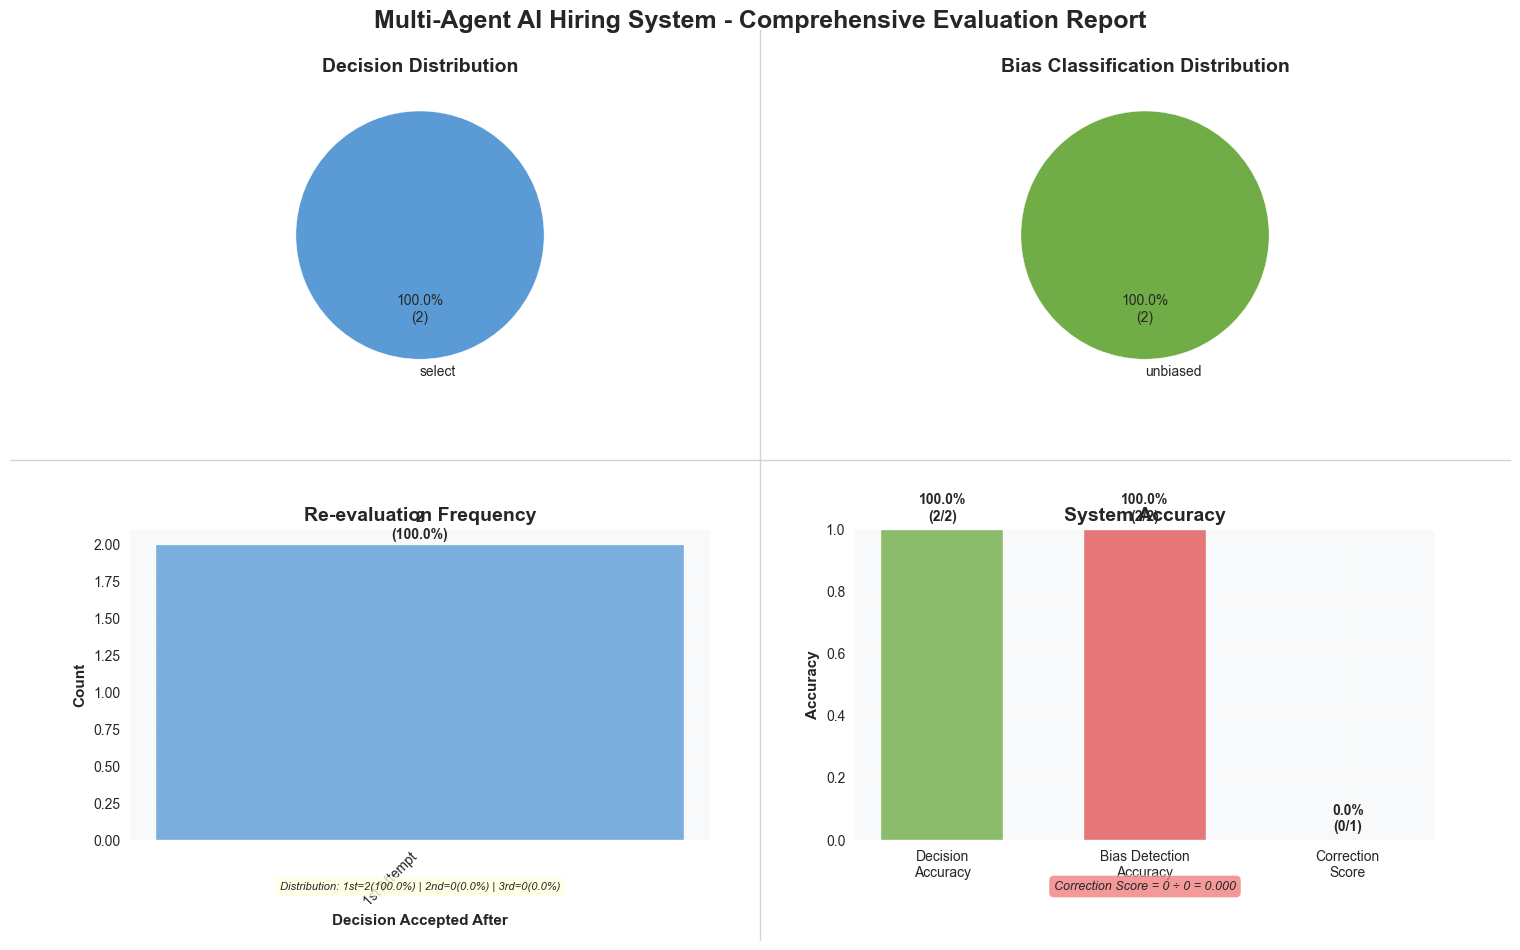

🔄 Enhanced workflow diagram saved to: results/images/workflow_diagram.png


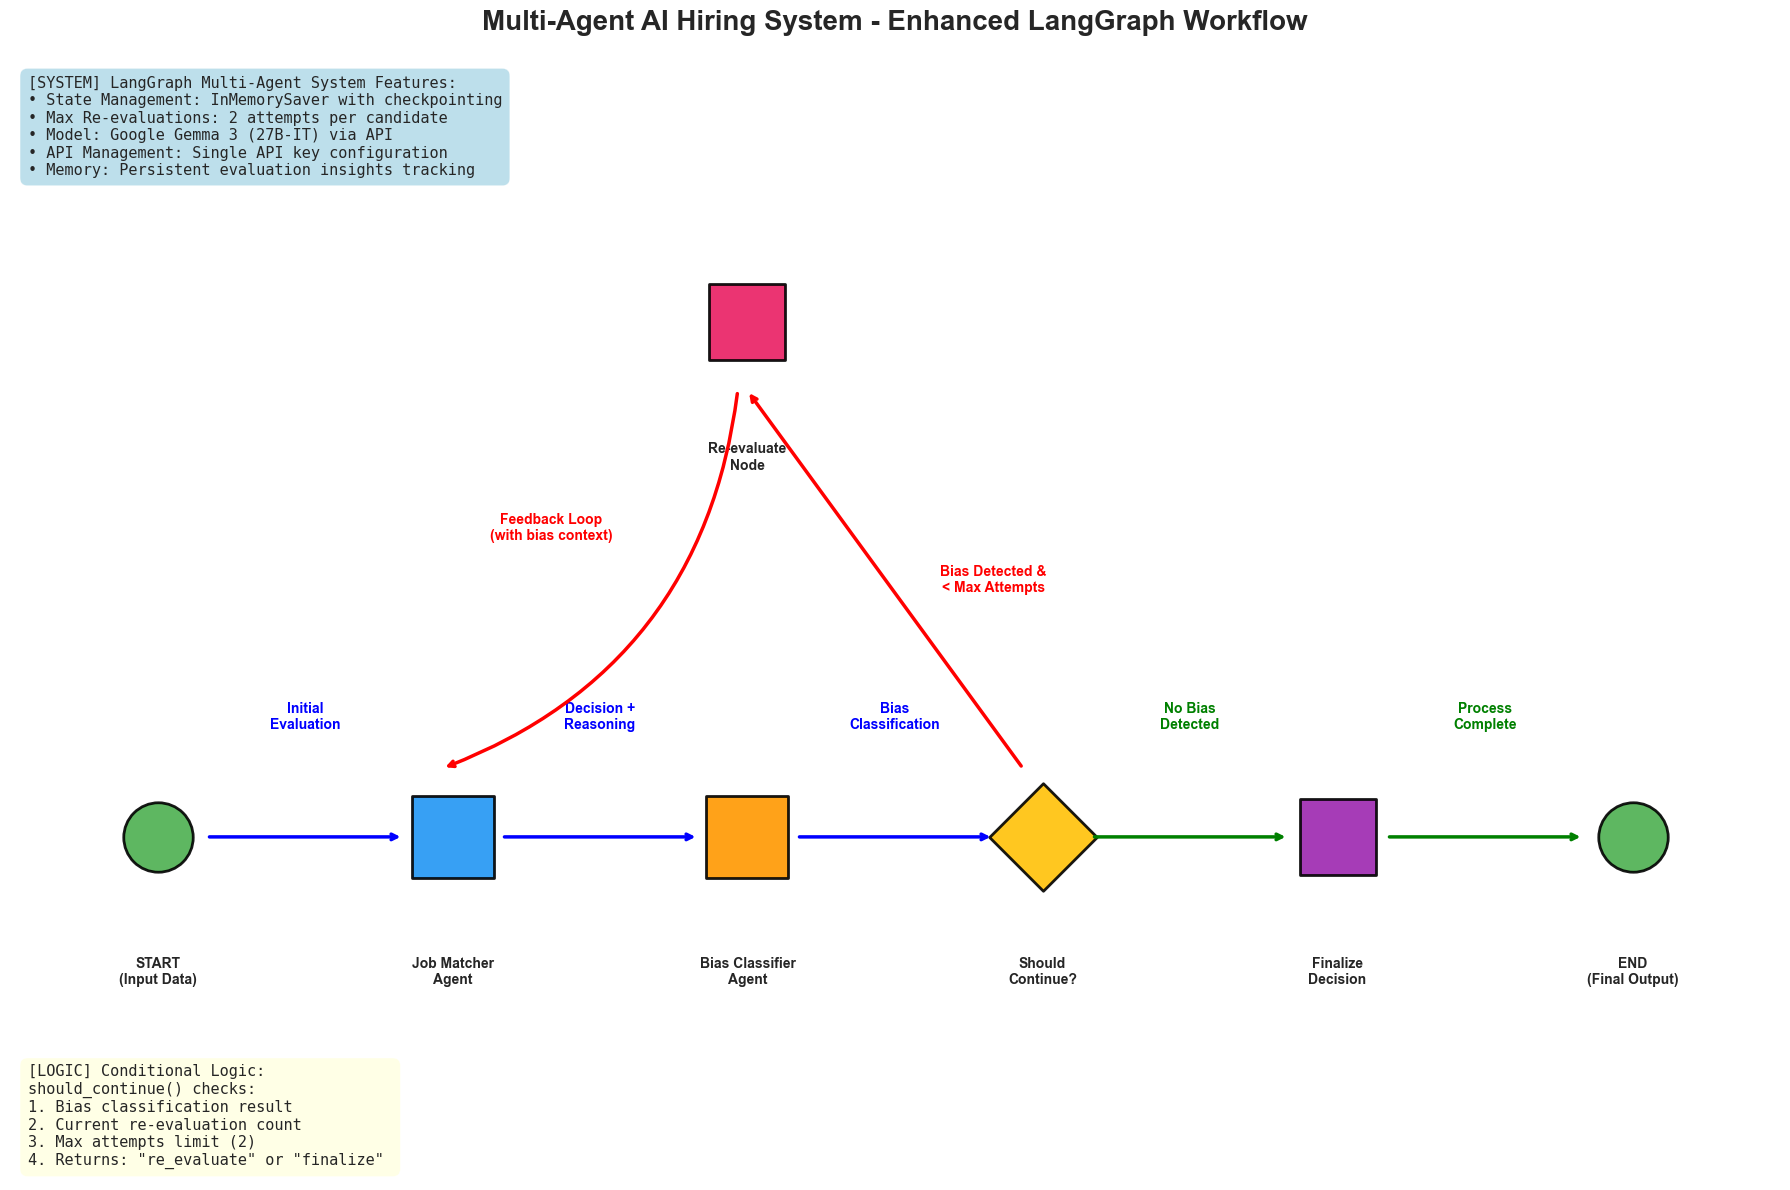

🔧 CORRECTION PERFORMANCE ANALYSIS
📊 CORRECTION STATISTICS:
  • Total Biased Cases in Dataset: 0
  • Successfully Corrected Cases: 0
  • Correction Rate: 0.0%

✅ All charts created successfully!
📋 Generated charts:
   • evaluation_results.png - Enhanced 4-panel evaluation with equations and numbers
   • workflow_diagram.png - Enhanced LangGraph workflow visualization


In [33]:
generator = HiringSystemChartGenerator()

if evaluation_only:
    generator.create_evaluation_charts(results, output)
elif workflow:
    generator.create_workflow_diagram()
else:
    # Default behavior: create all charts
    generator.create_all_charts(results)